In [238]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from scipy.ndimage import gaussian_filter

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,kpss







plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# EDA

## Data Loading

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')

In [7]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# function to rename columns in lower case
def lower_case(dataframe):
    cols = dataframe.columns.tolist()
    cols = [col.lower() for col in cols]
    dataframe.columns = cols
    return dataframe

In [42]:
lower_case(df_train);
lower_case(df_store);
lower_case(df_test);

In [10]:
# function to change date into datetime
def to_datetime(dataframe):
    dataframe.assign(
        timestamp = lambda x: pd.to_datetime(x['date']),
        year = lambda x: x['timestamp'].dt.year,
        month = lambda x: x['timestamp'].dt.month,
        day = lambda x: x['timestamp'].dt.day,
        dayofyear = lambda x: x['timestamp'].dt.dayofyear)
    return dataframe
# does not work :( 

In [11]:
#df_train = to_datetime(df_train)

In [13]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_train = df_train.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_train.drop("date", inplace=True, axis=1)

In [14]:
df_train.head()

,store,dayofweek,sales,customers,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear
0,1,5,5263,555,1,1,0,1,2015-07-31,2015,7,31,212
1,2,5,6064,625,1,1,0,1,2015-07-31,2015,7,31,212
2,3,5,8314,821,1,1,0,1,2015-07-31,2015,7,31,212
3,4,5,13995,1498,1,1,0,1,2015-07-31,2015,7,31,212
4,5,5,4822,559,1,1,0,1,2015-07-31,2015,7,31,212


In [26]:
print(df_store.shape)
df_store.head()

(1115, 10)


,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Data Cleaning

In [15]:
df_train.shape

(1017209, 13)

### Closed stores and zero sales stores

In [154]:
# closed stores
df_train[(df_train['open'] == 0) & (df_train['sales'] == 0)].shape

(172817, 13)

In [153]:
df_train[(df_train['open'] != 0) & (df_train['sales'] == 0)].shape

(54, 13)

There are 172817 stores, which were closed and had no sales. In addition to 54 open stores, which had no sales at that day.

We cannot make any predictions for stores, which were closed, and stores which were open, but had no sales, might have had external influences, such as remodeling.

To avoid any bias, we should drop these datapoints with 0 sales.

In [156]:
df_train = df_train[(df_train["open"] != 0) & (df_train['sales'] != 0)]
df_train.shape

(844338, 13)

In [157]:
df_train['stateholiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [158]:
df_train.stateholiday.value_counts()

0    843428
a       694
b       145
c        71
Name: stateholiday, dtype: int64

In [159]:
df_train['stateholiday'].replace({0:'0'}, inplace=True)
round(df_train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.42,321.73,1.0,280.0,558.0,837.0,1115.0
dayofweek,844338.0,3.52,1.72,1.0,2.0,3.0,5.0,7.0
sales,844338.0,6955.96,3103.82,46.0,4859.0,6369.0,8360.0,41551.0
customers,844338.0,762.78,401.19,8.0,519.0,676.0,893.0,7388.0
open,844338.0,1.00,0.00,1.0,1.0,1.0,1.0,1.0
promo,844338.0,0.45,0.50,0.0,0.0,0.0,1.0,1.0
schoolholiday,844338.0,0.19,0.40,0.0,0.0,0.0,0.0,1.0
year,844338.0,2013.83,0.78,2013.0,2013.0,2014.0,2014.0,2015.0
month,844338.0,5.85,3.32,1.0,3.0,6.0,8.0,12.0
day,844338.0,15.84,8.68,1.0,8.0,16.0,23.0,31.0


### Cleaning NaN's

In [160]:
df_store.isnull().sum()

store                        0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
dtype: int64

In [161]:
df_store[pd.isnull(df_store.competitiondistance)]

,store,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval


In [162]:
# fill NaN with a median value
df_store['competitiondistance'].fillna(df_store['competitiondistance'].median(), inplace = True)
df_store['competitiondistance'].isnull().sum()

0

In [163]:
tmp = df_store[pd.isnull(df_store.competitionopensinceyear)]
tmp[tmp.competitiondistance != 0].shape

(0, 10)

Here these stores have a competition in their vicinity ('competitiondistance' =/= 0), but there is no information about the year this competition has been open. This value needs to be imputed in a meaningful way. Or just filled with '0'.

In [164]:
tmp = df_store[pd.isnull(df_store.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 10)

There are no stores with information about 'promo2sinceweek' which have 'NaN' in promo2.

In [165]:
# replace NA's by 0
df_store.fillna(0, inplace = True)

In [166]:
print(df_store.isnull().sum())
print('------------------------')
print(df_train.isnull().sum())

store                        0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
dtype: int64
------------------------
store            0
dayofweek        0
sales            0
customers        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64


All the cleaning can also be done to the test dataset.

In [167]:
print(df_test.head())
print('------------------------------------------')
print(df_test.info())

   id  store  dayofweek  open  promo stateholiday  schoolholiday  timestamp  \
0   1      1          4     1      1            0              0 2015-09-17   
1   2      3          4     1      1            0              0 2015-09-17   
2   3      7          4     1      1            0              0 2015-09-17   
3   4      8          4     1      1            0              0 2015-09-17   
4   5      9          4     1      1            0              0 2015-09-17   

   year  month  day  dayofyear  
0  2015      9   17        260  
1  2015      9   17        260  
2  2015      9   17        260  
3  2015      9   17        260  
4  2015      9   17        260  
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             41088 non-null  int64         
 1   store          41

In [44]:
# changing date into datetime object, inserting year, month, day and dayofyear columns
df_test = df_test.assign(
            timestamp = lambda x: pd.to_datetime(x['date']),
            year = lambda x: x['timestamp'].dt.year,
            month = lambda x: x['timestamp'].dt.month,
            day = lambda x: x['timestamp'].dt.day,
            dayofyear = lambda x: x['timestamp'].dt.dayofyear)
df_test.drop("date", inplace=True, axis=1)

In [171]:
print(df_test['stateholiday'].unique())
print(df_test['stateholiday'].value_counts())

['0' 'a']
0    40908
a      180
Name: stateholiday, dtype: int64


In [172]:
df_test[df_test["open"].isnull()]

,id,store,dayofweek,open,promo,stateholiday,schoolholiday,timestamp,year,month,day,dayofyear


All of these store have no information for 'open', although these days are not a holiday ('stateholiday =/= 1) and are not affected by the closure of schools. They should be open.

In [66]:
df_test['open'].fillna(1, inplace=True)
df_test['open']= df_test['open'].astype(int)

In [69]:
df_test.isnull().sum()

id               0
store            0
dayofweek        0
open             0
promo            0
stateholiday     0
schoolholiday    0
timestamp        0
year             0
month            0
day              0
dayofyear        0
dtype: int64

## Data Exploration

In [169]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.store, right_on=df_store.store)
df.drop(['key_0', 'store_y'], axis=1, inplace=True)
df = df.rename(columns={'store_x':'store'})

In [170]:
df.groupby('storetype')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
storetype,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [173]:
df.groupby('storetype')['customers', 'sales'].sum()

,customers,sales
storetype,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


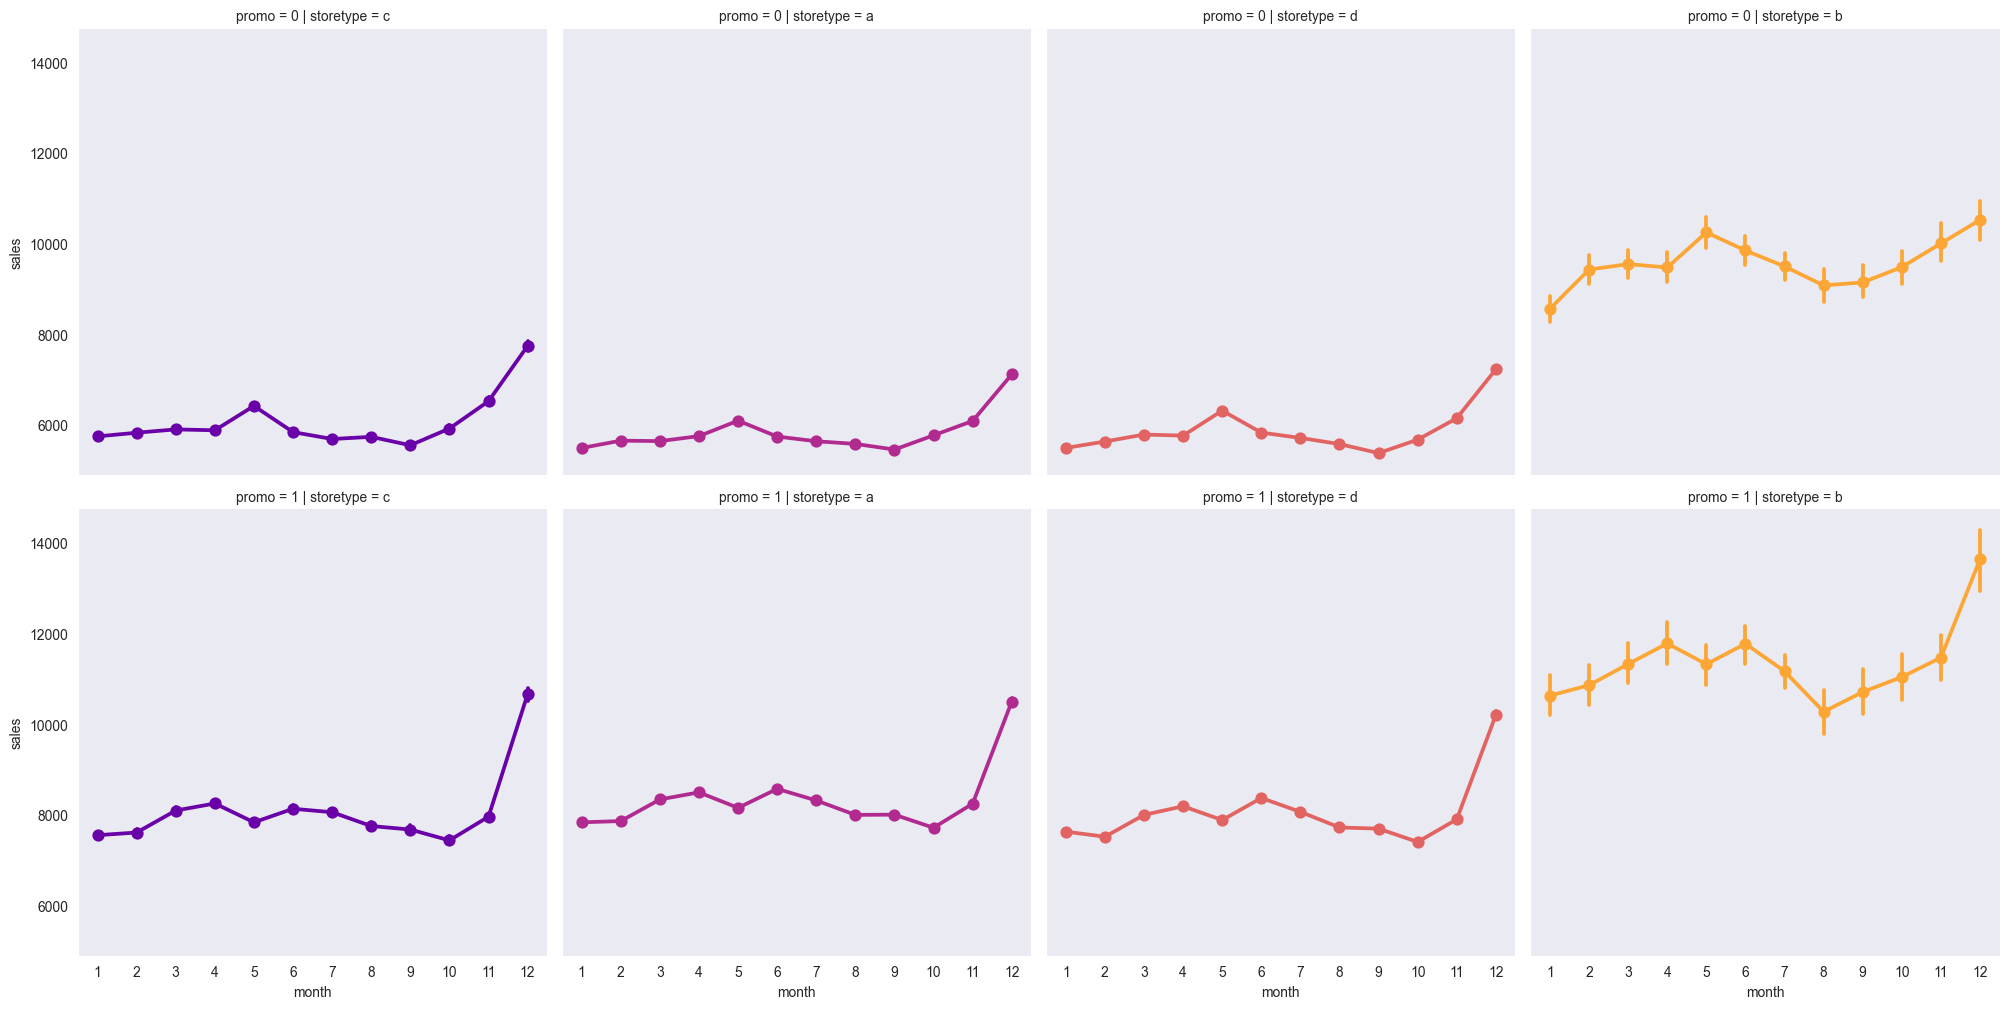

In [175]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

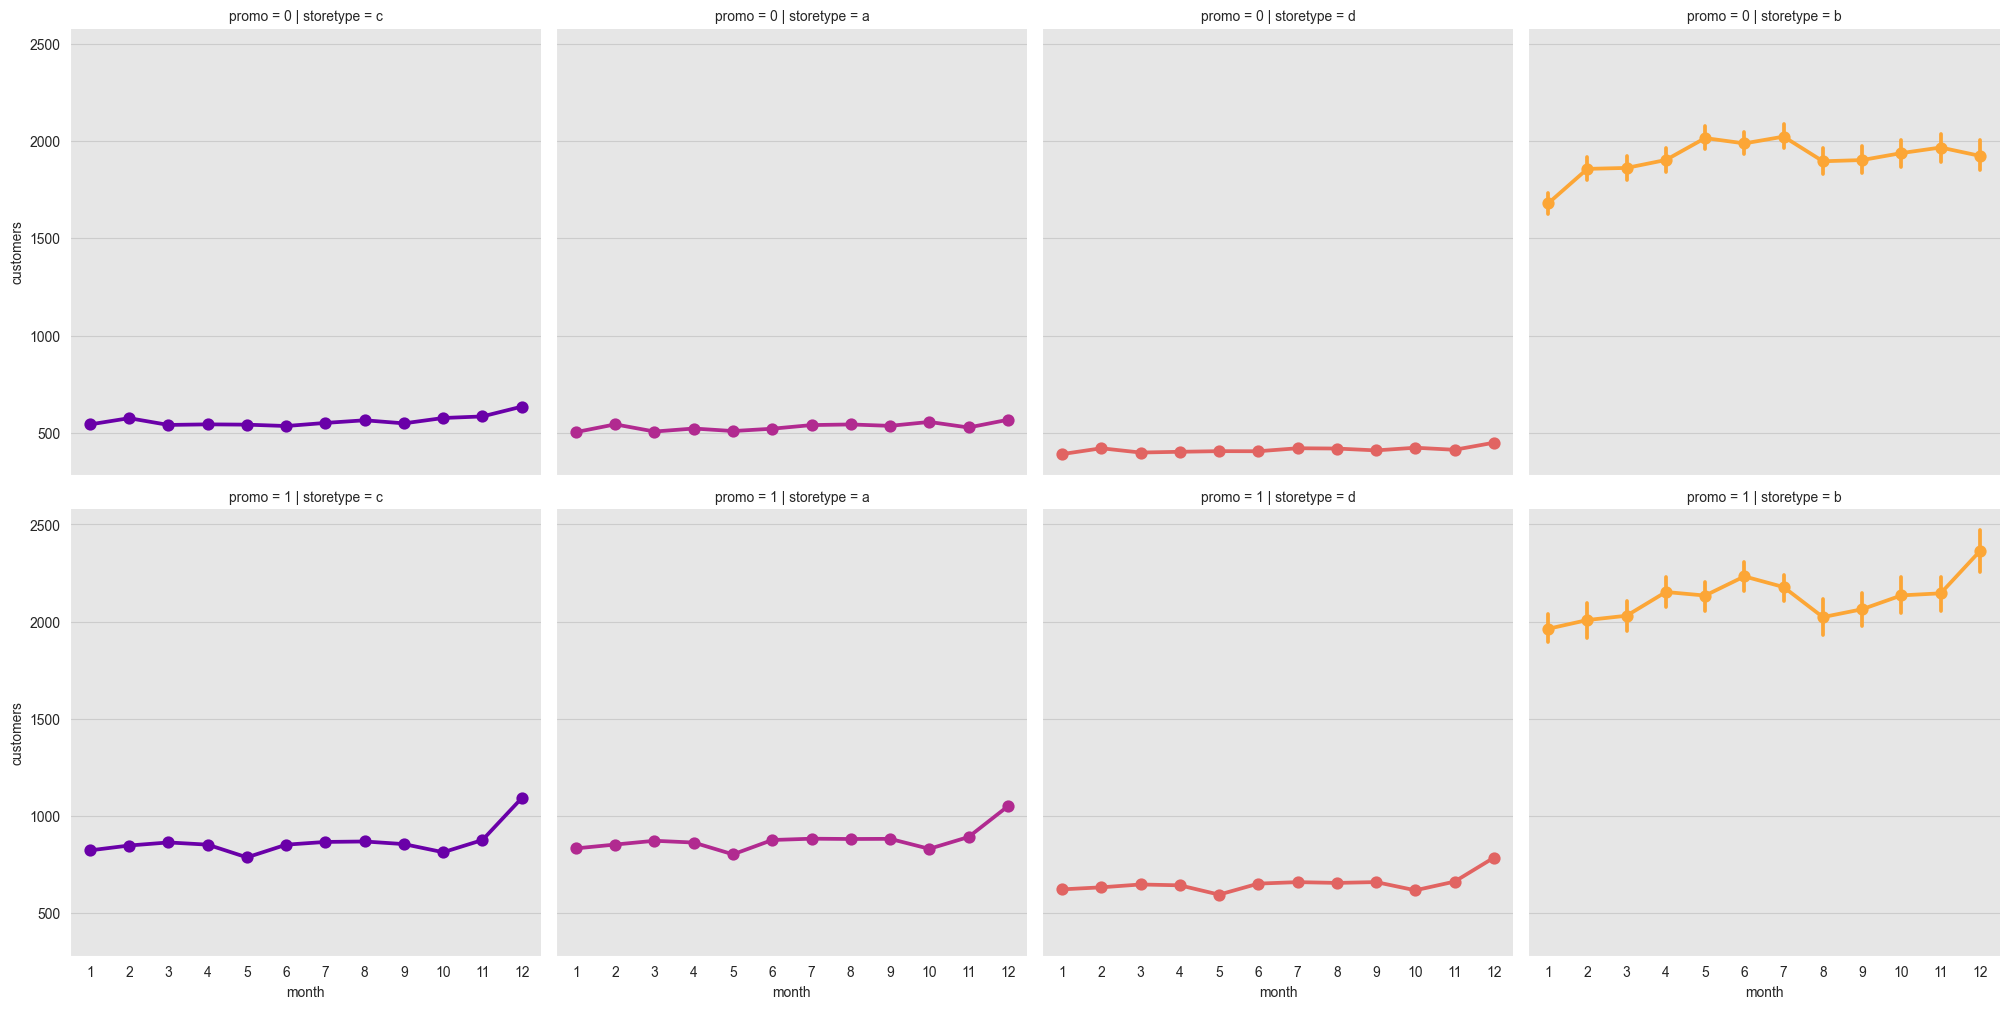

In [88]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

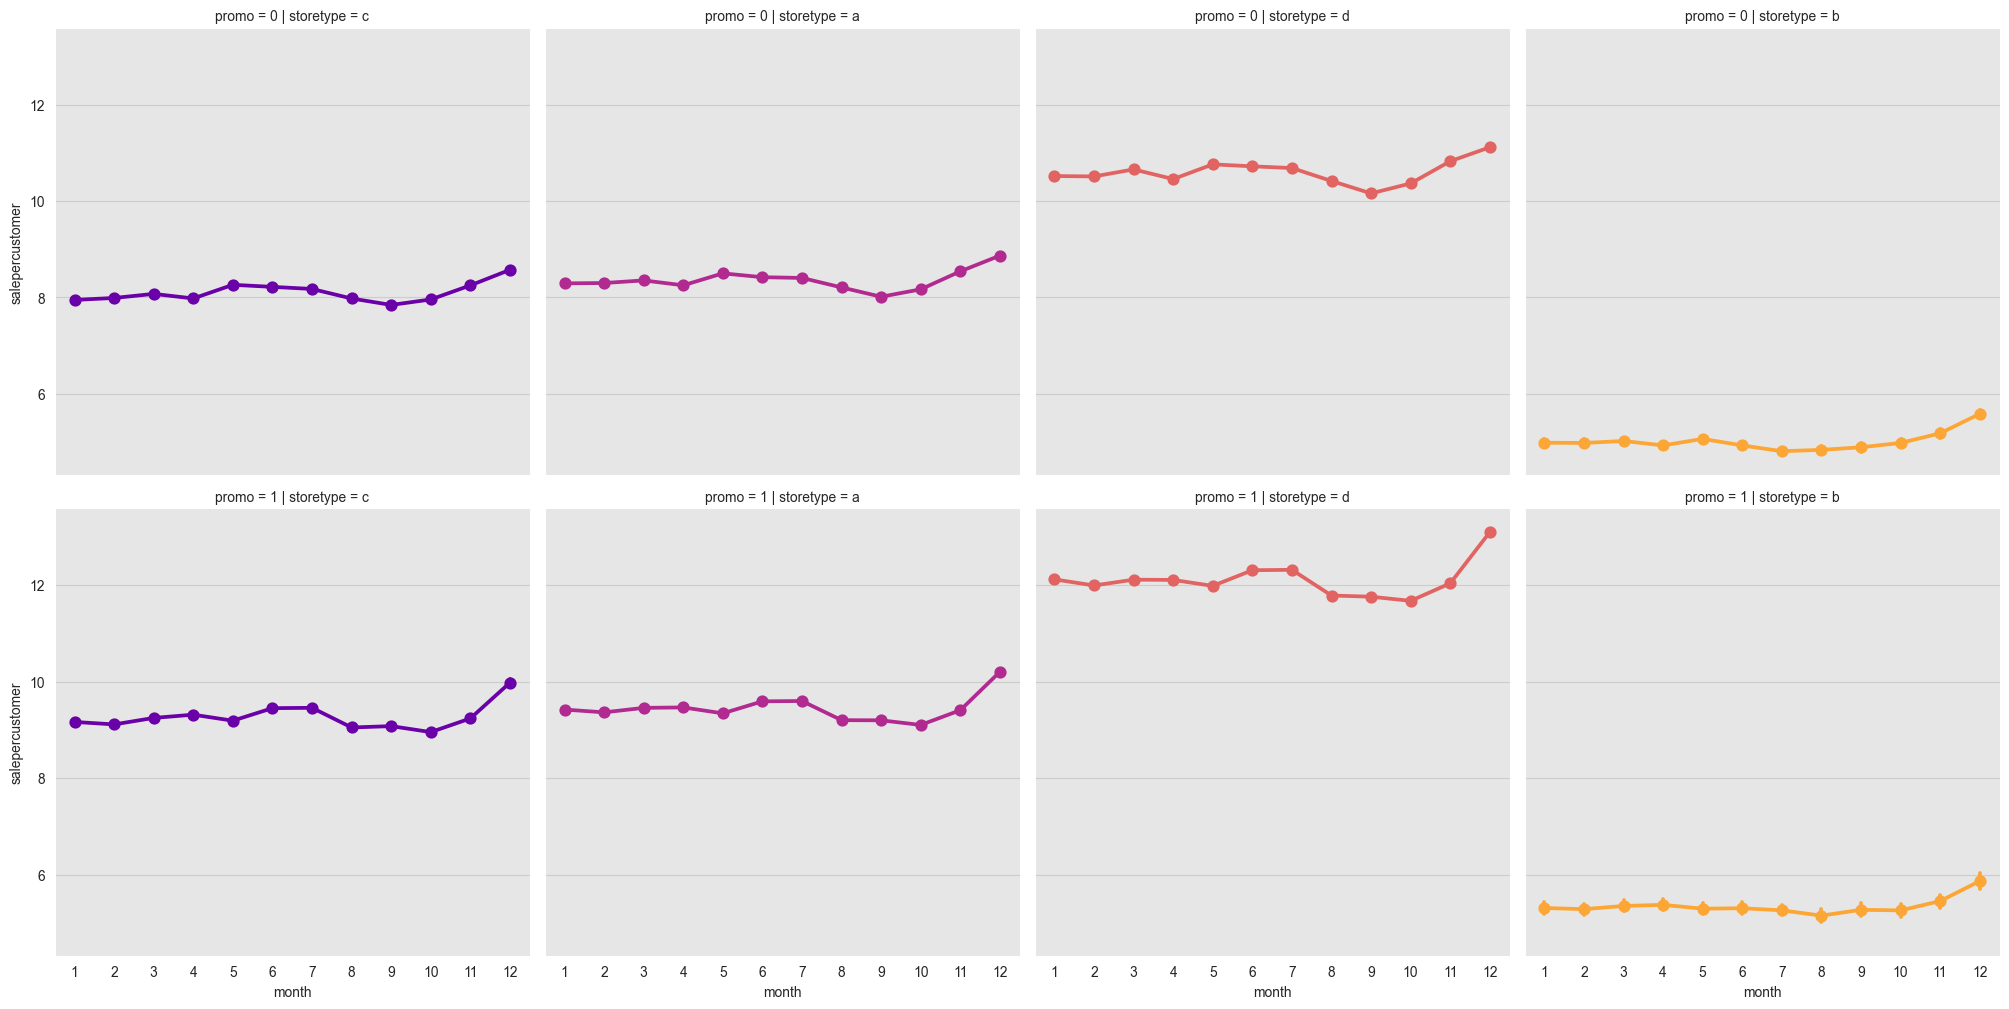

In [89]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

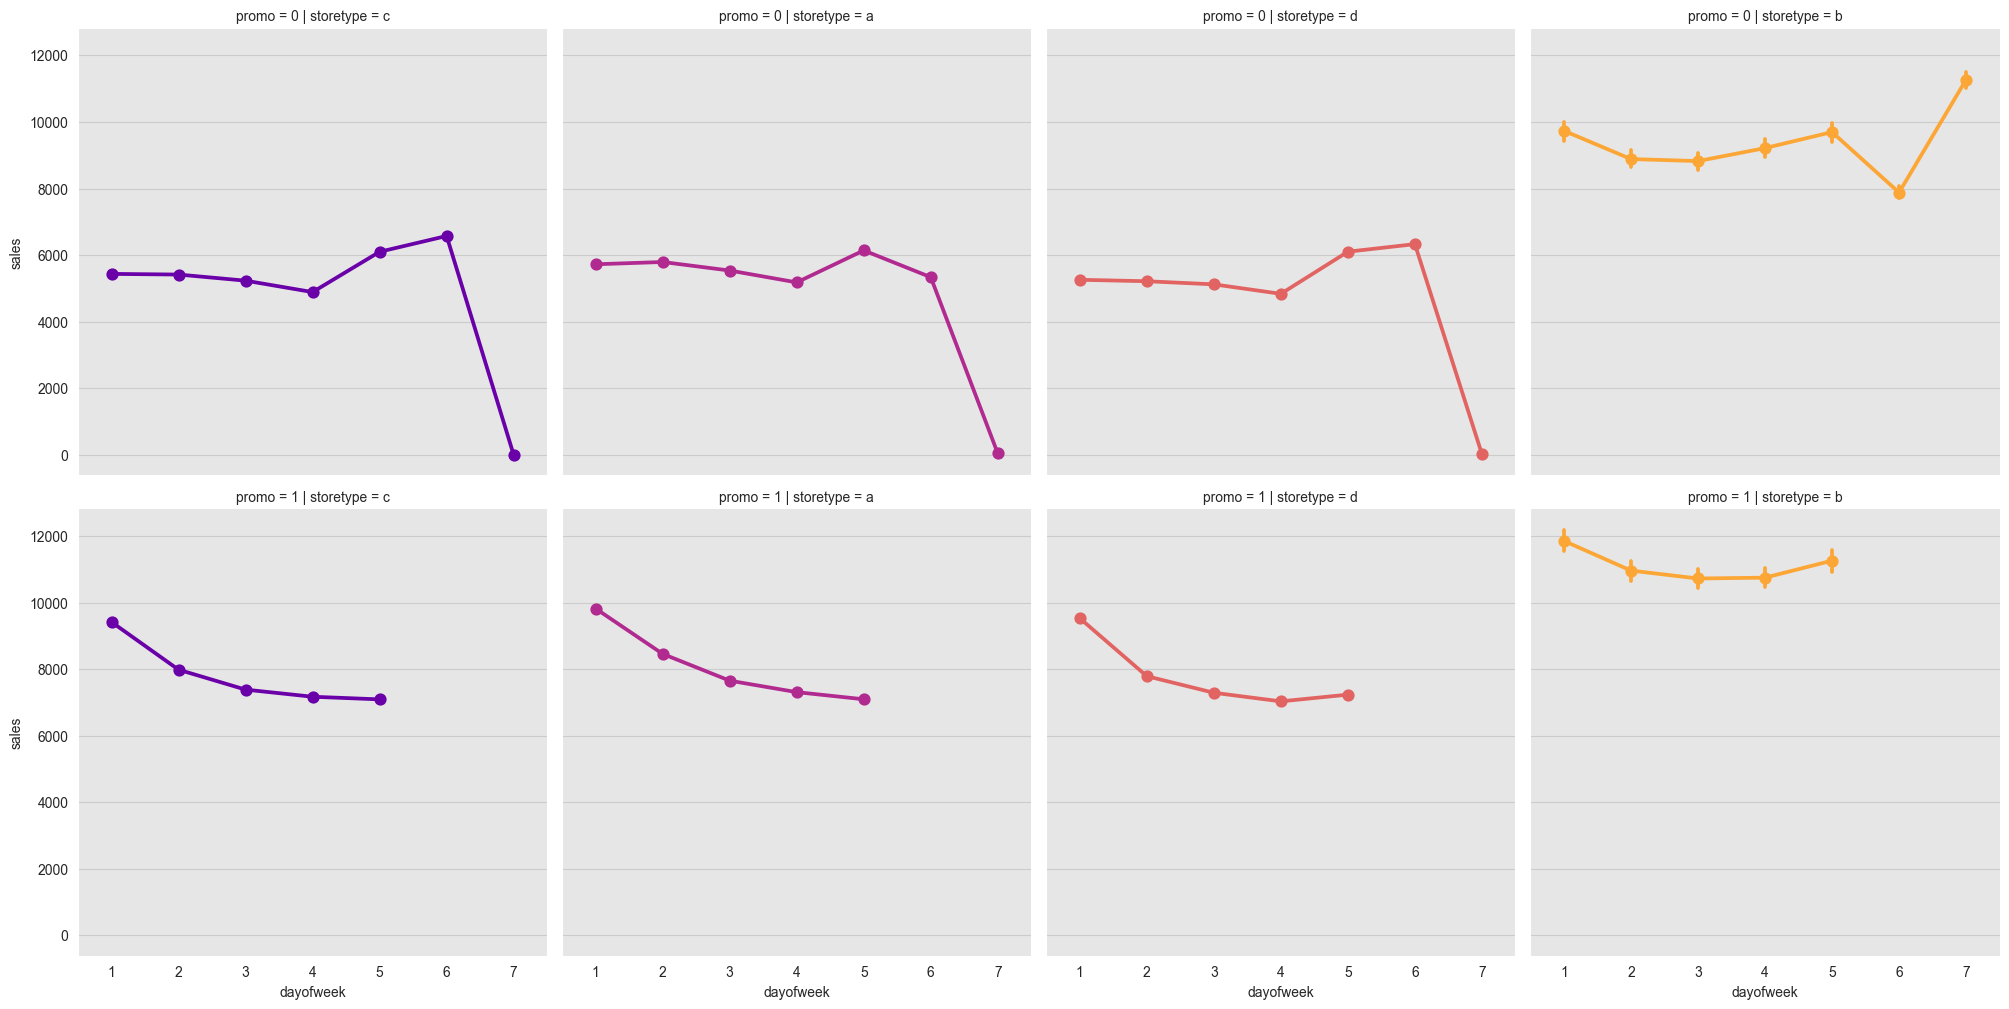

In [90]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

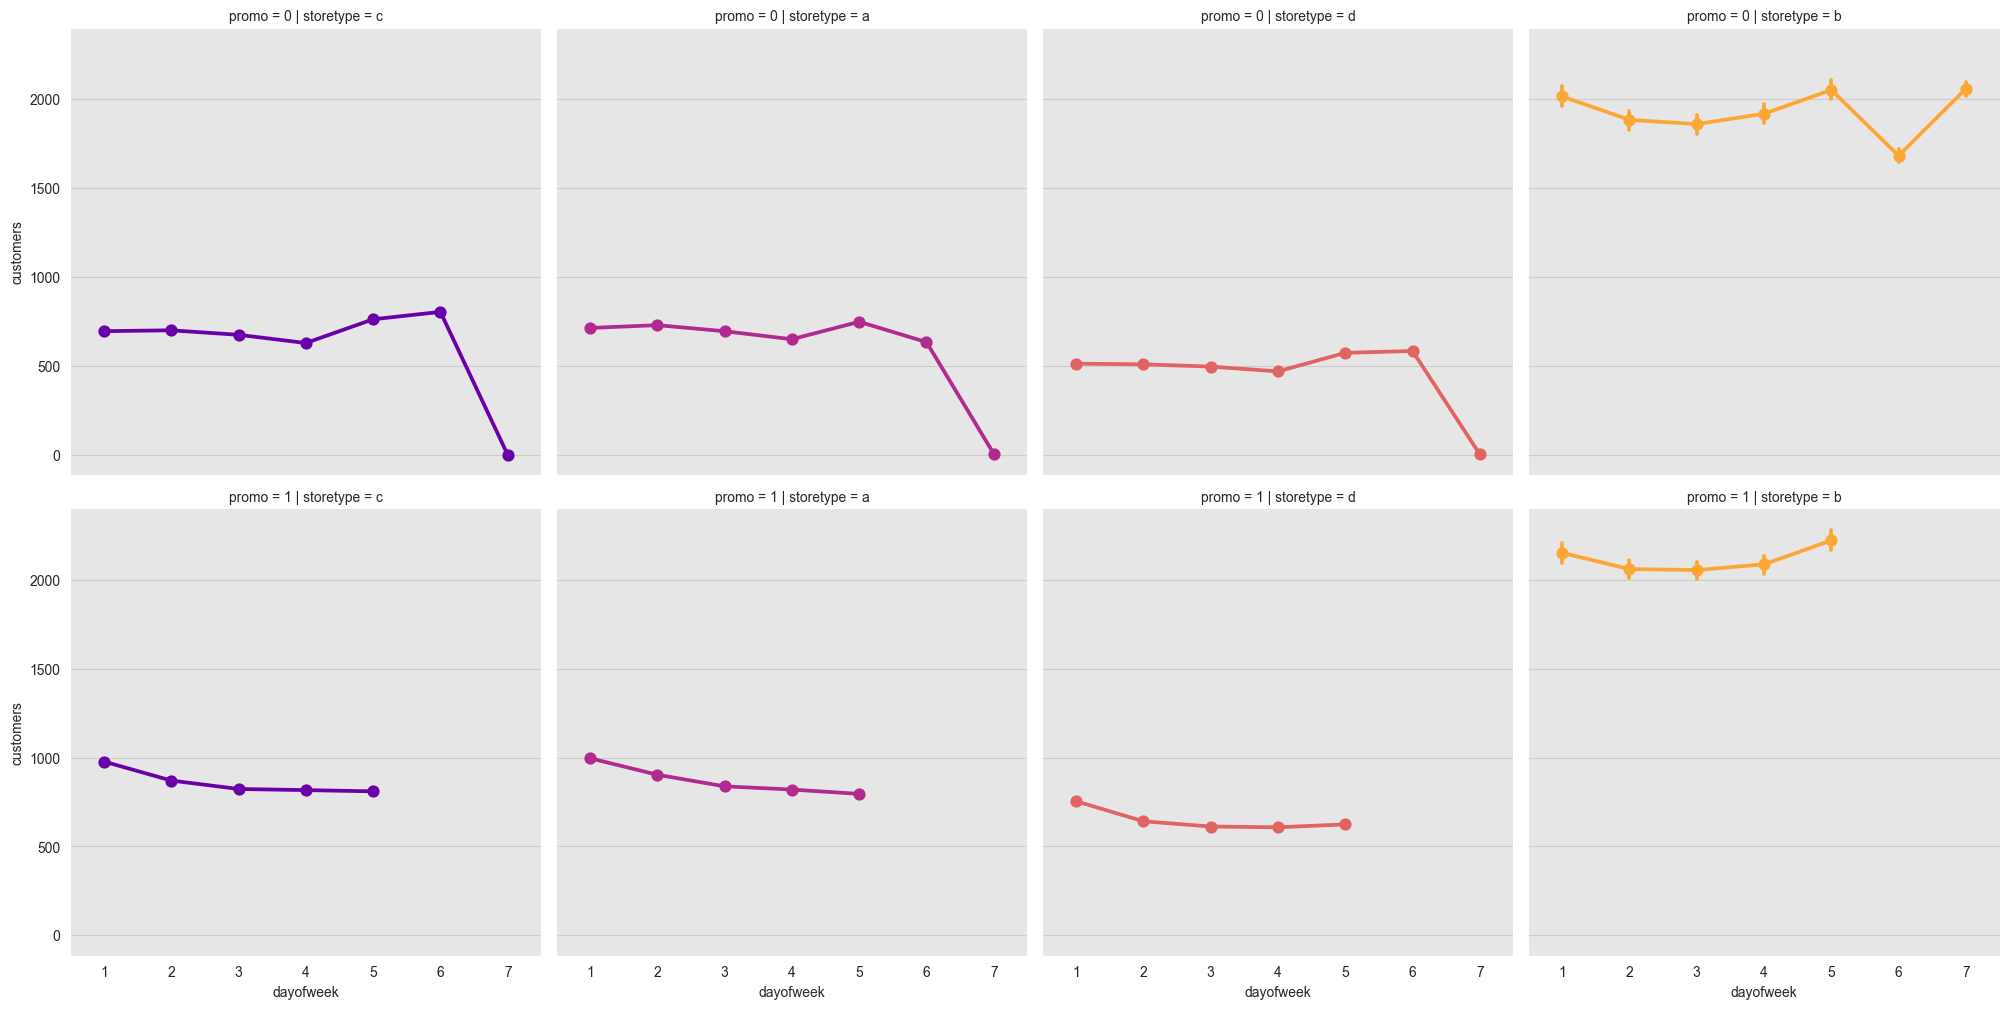

In [92]:
# weekday customer trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

### Conclusion:
- Promos are run only during the work-week, no promo on saturday/sunday\n",
- Storetype B has the highest number of customers, with the largest variance\n",
- Storetype B has the highest sales numbers, with the largest variance\n",
- All storetypes show increased sales numbers towards christmas\n",
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo."

In [102]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.43,321.91,1.0,280.0,558.00,838.0,1115.00
dayofweek,1017209.0,4.00,2.00,1.0,2.0,4.00,6.0,7.00
sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.00,7856.0,41551.00
customers,1017209.0,633.15,464.41,0.0,405.0,609.00,837.0,7388.00
open,1017209.0,0.83,0.38,0.0,1.0,1.00,1.0,1.00
promo,1017209.0,0.38,0.49,0.0,0.0,0.00,1.0,1.00
schoolholiday,1017209.0,0.18,0.38,0.0,0.0,0.00,0.0,1.00
year,1017209.0,2013.83,0.78,2013.0,2013.0,2014.00,2014.0,2015.00
month,1017209.0,5.85,3.33,1.0,3.0,6.00,8.0,12.00
day,1017209.0,15.70,8.79,1.0,8.0,16.00,23.0,31.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

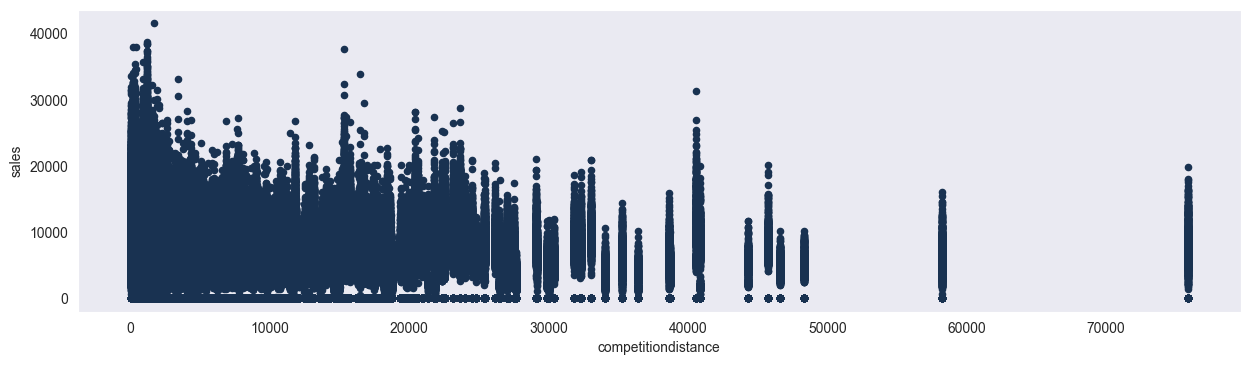

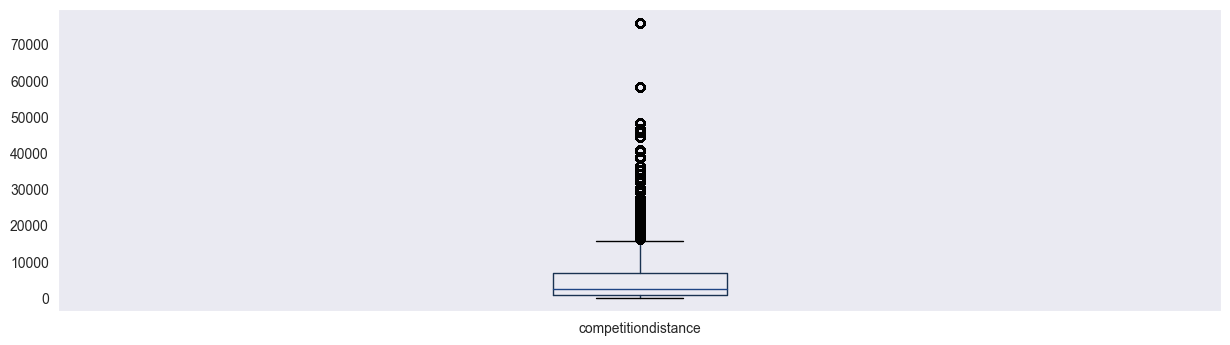

In [130]:
# Plot CompetitionDistance Vs Sales
df.plot(kind='scatter',x='competitiondistance',y='sales', figsize=(15,4))
df.plot(kind='box', y='competitiondistance', figsize=(15,4))

75% of all stores have their nearest competitor at under 7km distance, while 50% of all stores have their nearest competitor at 2.3km.

<AxesSubplot:xlabel='storetype', ylabel='competitiondistance'>

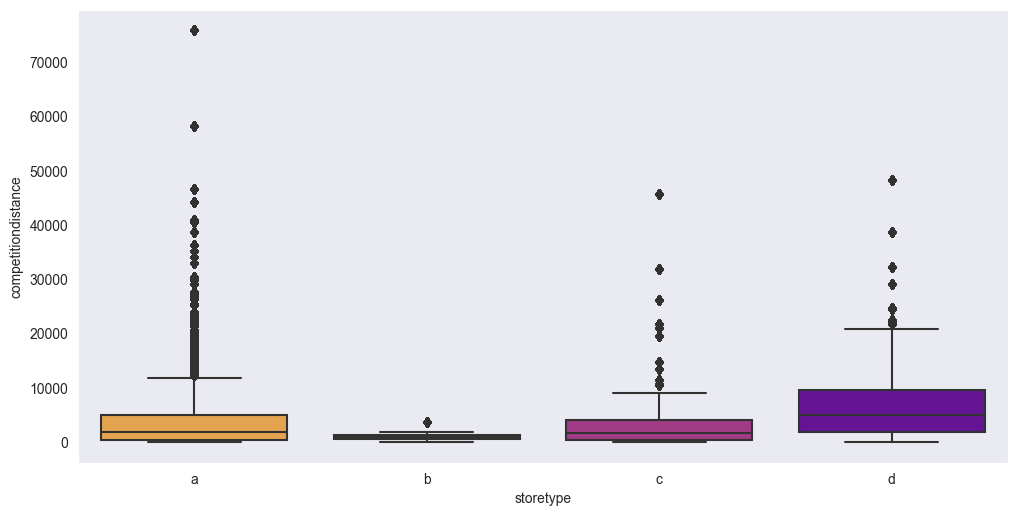

In [135]:
sns.boxplot(data= df, x= 'storetype', y= 'competitiondistance', palette = 'plasma_r', order=["a", "b", "c", "d"])

Storetype B has the nearest competitors, while storetyp D has the largest range and the largest mean distance. The farthest away competitors belong to Storetype A.

<AxesSubplot:xlabel='storetype', ylabel='sales'>

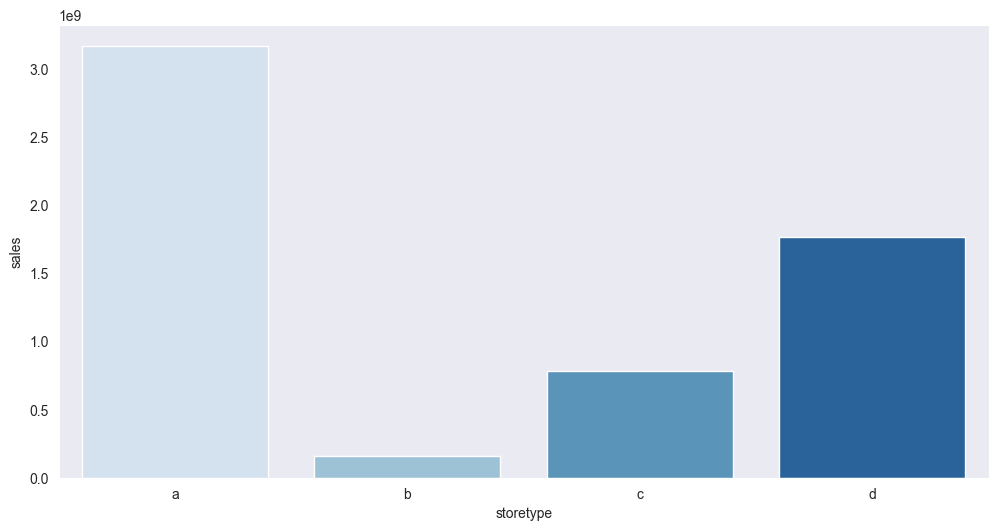

In [138]:
temp_df = df.groupby(df.storetype).sum()
sns.barplot(temp_df.index, temp_df.sales, palette='Blues')

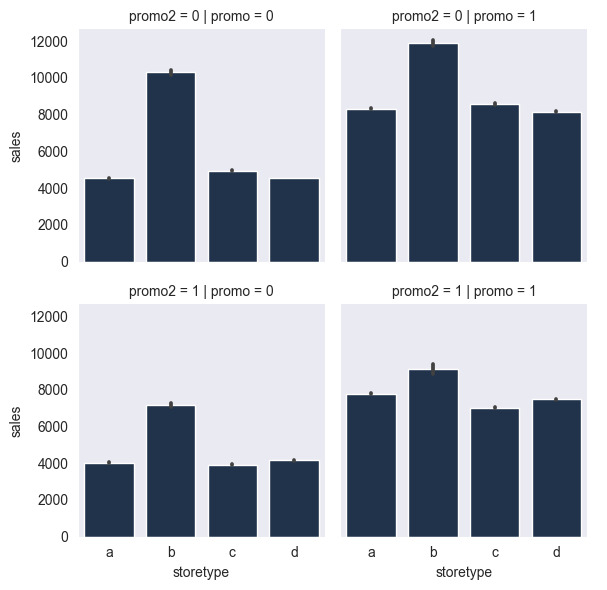

In [118]:
# plotting sales per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df,
                  col = 'promo',
                  row = 'promo2',
                  palette = 'plasma',
                  #hue = 'assortment',
                 )
g.map_dataframe(sns.barplot, "storetype", "sales", order=["a","b","c","d"])

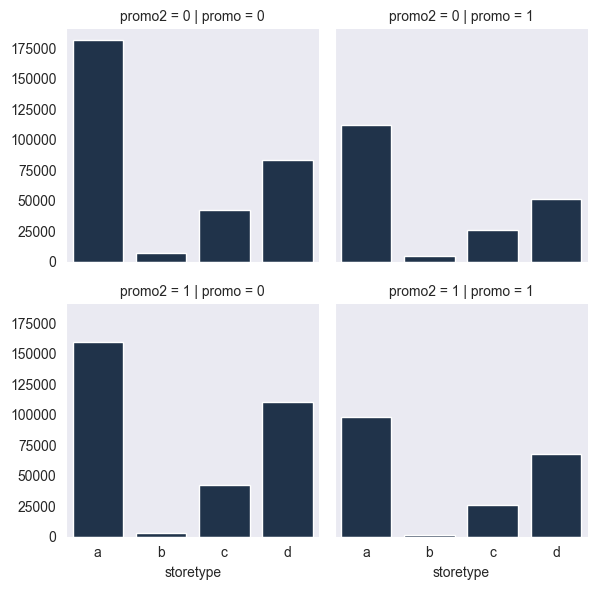

In [122]:
# plotting counts per storetype, based on promo1 or promo2
g = sns.FacetGrid(data = df, 
               col = 'promo',
                  row = 'promo2',
               palette = 'plasma',
               #hue = 'assortment',
               )
g.map_dataframe(sns.countplot, "storetype", order=["a","b","c","d"])
g.add_legend()

### Datatype and Encoding of Features

# Time Series Analysis

Plotting the seasonal decomposition of the sales per date. For this, the data for each day will be summed up and grouped by.

Afterwards, the model will decompose the sale values in an additive manner.

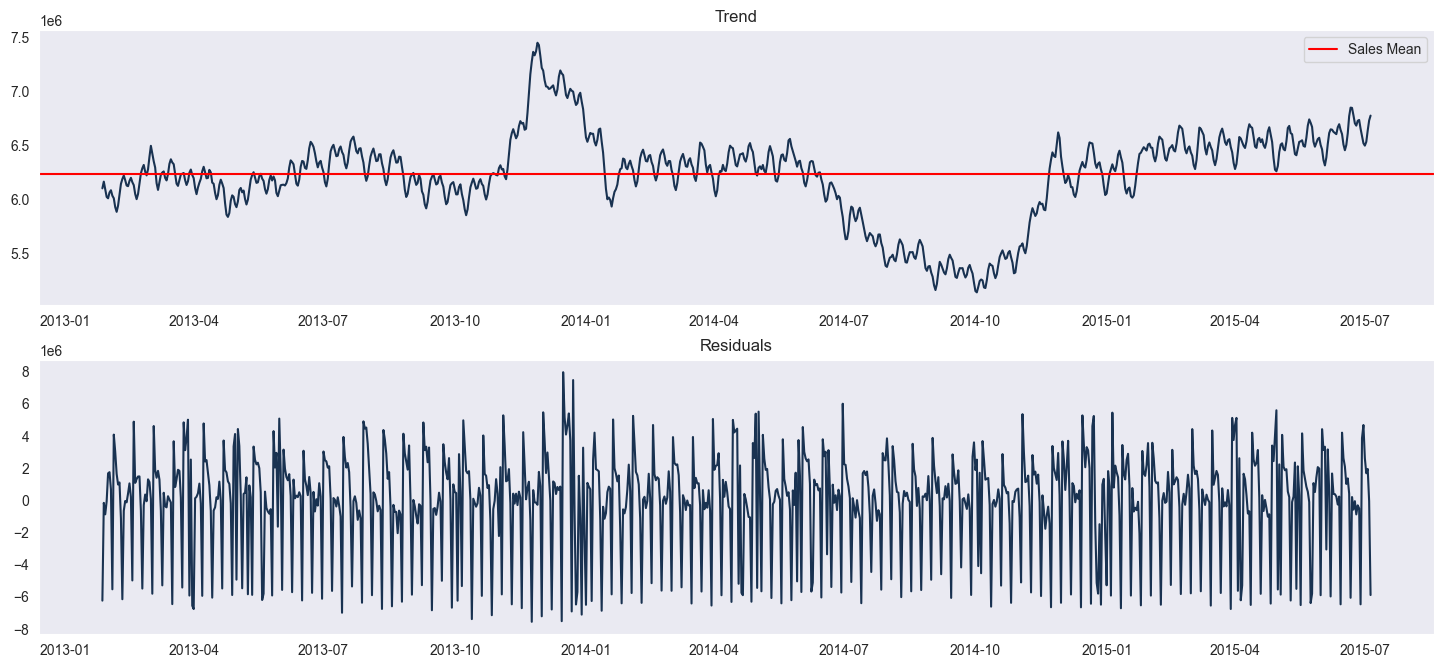

In [188]:
tmp_df = df.groupby(df['timestamp']).sum()
season_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(season_decomp.trend)
ax1.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(season_decomp.resid)
ax2.set_title("Residuals")
ax1.legend()
plt.show()

The beginning of 2014 and 2015 show higher than average sales numbers. Especially the peak at the beginning of 2014 is very high.

During the second half of 2014, the sales drop significantly under the average value.

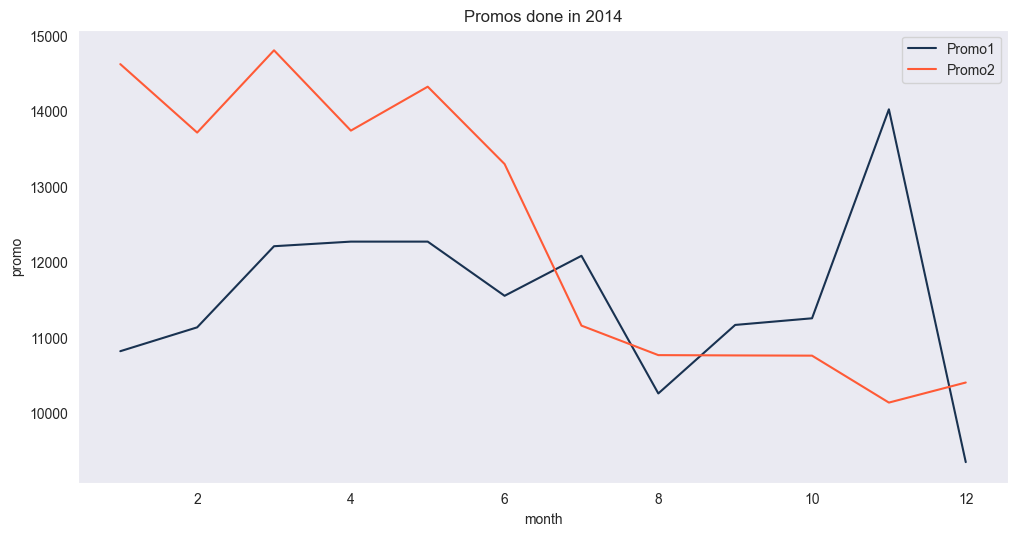

In [209]:
tmp_df = df.copy()
tmp_df = tmp_df[tmp_df['year']==2014]
tmp_df = tmp_df.groupby(tmp_df['month']).sum()

plt.title('Promos done in 2014')
sns.lineplot(data=tmp_df, x=tmp_df.index, y=tmp_df['promo'], palette='Blues', label='Promo1')
sns.lineplot(data=tmp_df, x=tmp_df.index, y=tmp_df['promo2'], palette='Blues', label='Promo2')
plt.legend()
plt.show()

The downwards trend of sales at the second half of 2014 until Christmas time seems to coincide with the decreasing number of promos during that period.

In [235]:
tmp_df = df.groupby(df['timestamp']).sum()

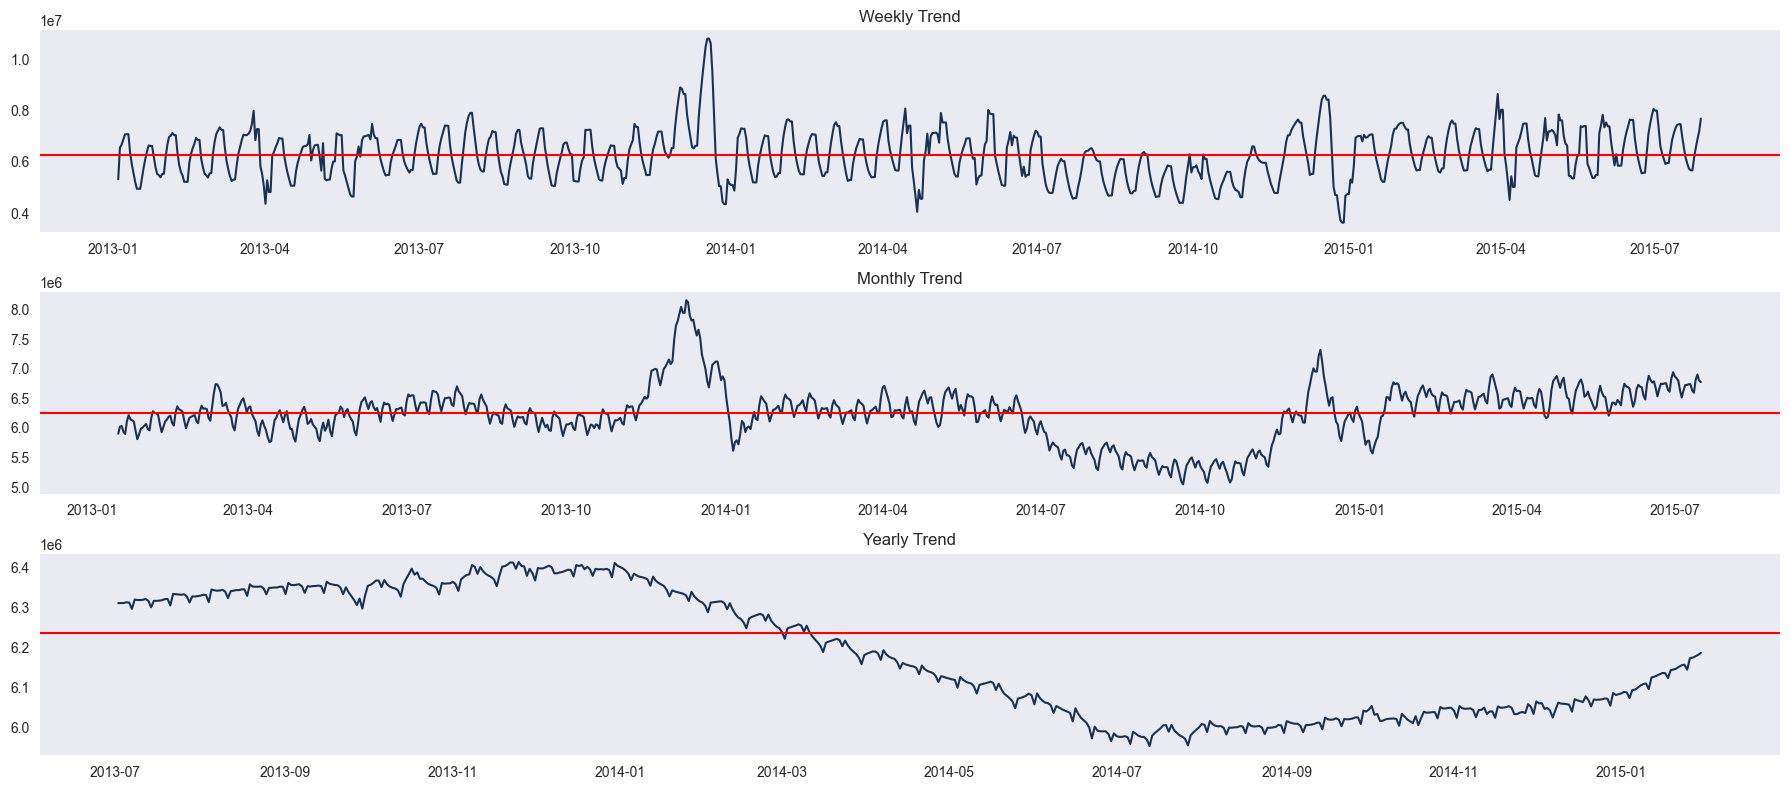

In [236]:
#freq = 7(weekly), 30(monthly), 365(yearly)
weekly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=7)
monthly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=30)
yearly_decomp = seasonal_decompose(tmp_df['sales'], model='additive', freq=365)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18,8))
ax1.plot(weekly_decomp.trend)
ax1.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Weekly Trend")
ax2.plot(monthly_decomp.trend)
ax2.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax2.set_title("Monthly Trend")
ax3.plot(yearly_decomp.trend)
ax3.axhline(y = tmp_df['sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax3.set_title("Yearly Trend")
fig.tight_layout() 
plt.show()

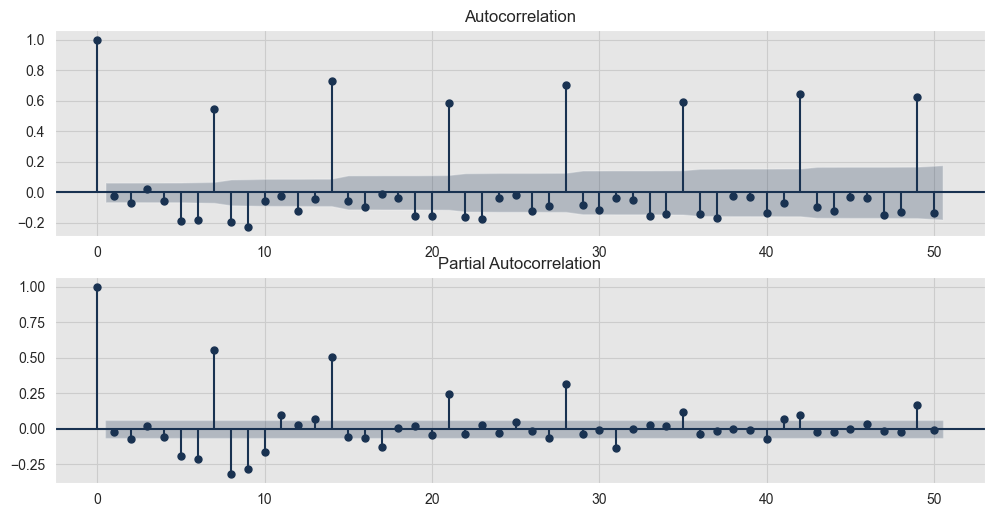

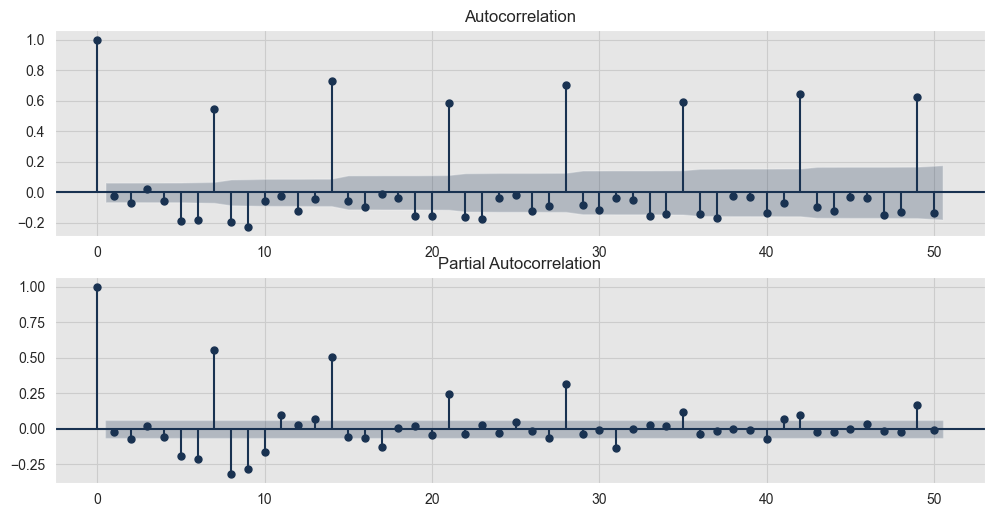

In [255]:
# Plot autocorrelation
f, (ax1, ax2) = plt.subplots(2, figsize = (12, 6))
plot_acf(tmp_df['sales'], lags = 50, ax=ax1)
plot_pacf(tmp_df['sales'], lags = 50, ax=ax2)

Those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

There is a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
